Dataset shape: (300000, 15)
  Country_of_Origin Education_Level Field_of_Study Language_Proficiency  \
0           Vietnam      Bachelor's             IT               Fluent   
1           Germany        Master's           Arts         Intermediate   
2            Brazil             PhD    Engineering         Intermediate   
3           Vietnam             PhD         Health               Fluent   
4           Nigeria             PhD    Engineering                Basic   

             Visa_Type  Gender University_Ranking Region_of_Study  Age  \
0  Permanent Residency  Female                Low              EU   23   
1           Post-study    Male               High              UK   38   
2           Post-study    Male               High          Canada   23   
3           Post-study  Female             Medium       Australia   25   
4              Student    Male               High          Canada   24   

   Years_Since_Graduation   GPA Internship_Experience Employment_Status  \
0

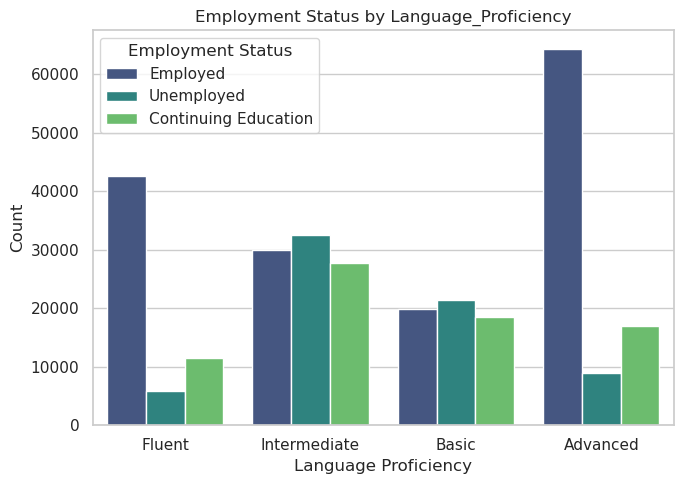

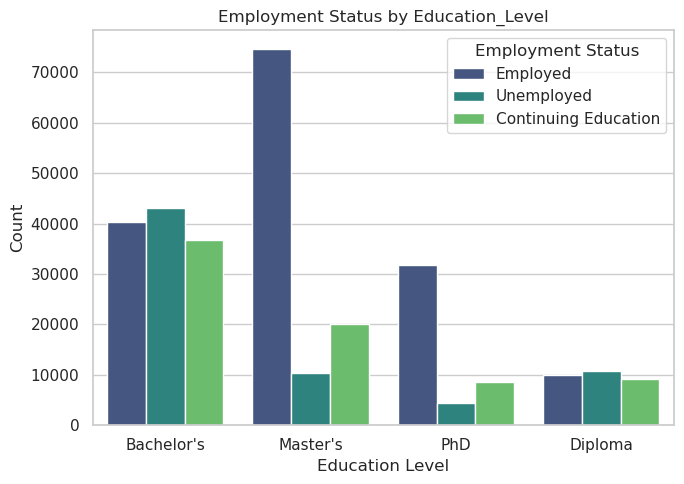

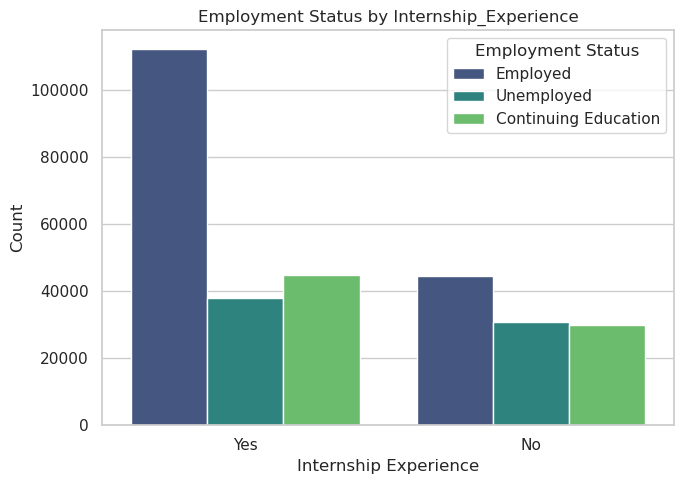


  Statistical Analysis for COMBINED PREDICTORS

Contingency Table: Language_Proficiency × Education_Level vs Employment_Status
Employment_Status                       Continuing Education  Employed  \
Language_Proficiency_x_Education_Level                                   
Advanced & Bachelor's                                   9928     18842   
Advanced & Diploma                                      2498      4652   
Advanced & Master's                                     3200     28553   
Advanced & PhD                                          1343     12234   
Basic & Bachelor's                                      8045      3618   
Basic & Diploma                                         2018       855   
Basic & Master's                                        5851     10822   
Basic & PhD                                             2555      4657   
Fluent & Bachelor's                                     6837     12552   
Fluent & Diploma                                        17

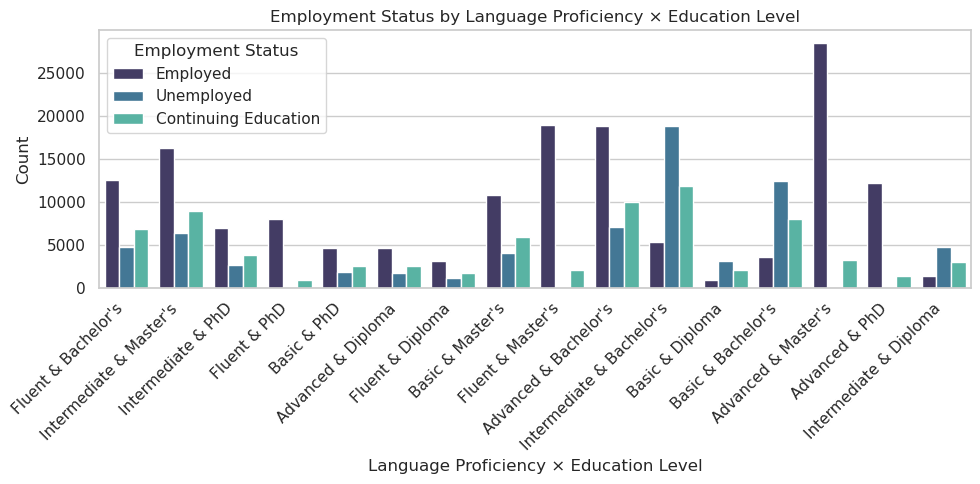


Contingency Table: Language_Proficiency × Internship_Experience vs Employment_Status
Employment_Status                             Continuing Education  Employed  \
Language_Proficiency_x_Internship_Experience                                   
Advanced & No                                                 7427     19681   
Advanced & Yes                                                9542     44600   
Basic & No                                                    7037      4725   
Basic & Yes                                                  11432     15227   
Fluent & No                                                   5013     12979   
Fluent & Yes                                                  6518     29545   
Intermediate & No                                            10435      7109   
Intermediate & Yes                                           17213     22778   
All                                                          74617    156644   

Employment_Status                

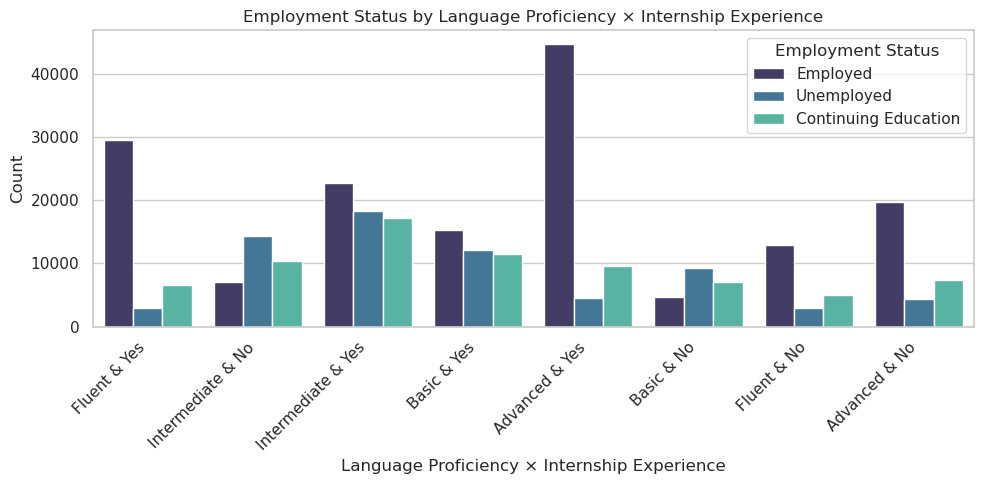


Contingency Table: Education_Level × Internship_Experience vs Employment_Status
Employment_Status                        Continuing Education  Employed  \
Education_Level_x_Internship_Experience                                   
Bachelor's & No                                         13762      9588   
Bachelor's & Yes                                        22952     30789   
Diploma & No                                             3515      2326   
Diploma & Yes                                            5719      7613   
Master's & No                                            8719     22957   
Master's & Yes                                          11334     51616   
PhD & No                                                 3916      9623   
PhD & Yes                                                4700     22132   
All                                                     74617    156644   

Employment_Status                        Unemployed     All  
Education_Level_x_Internship_Ex

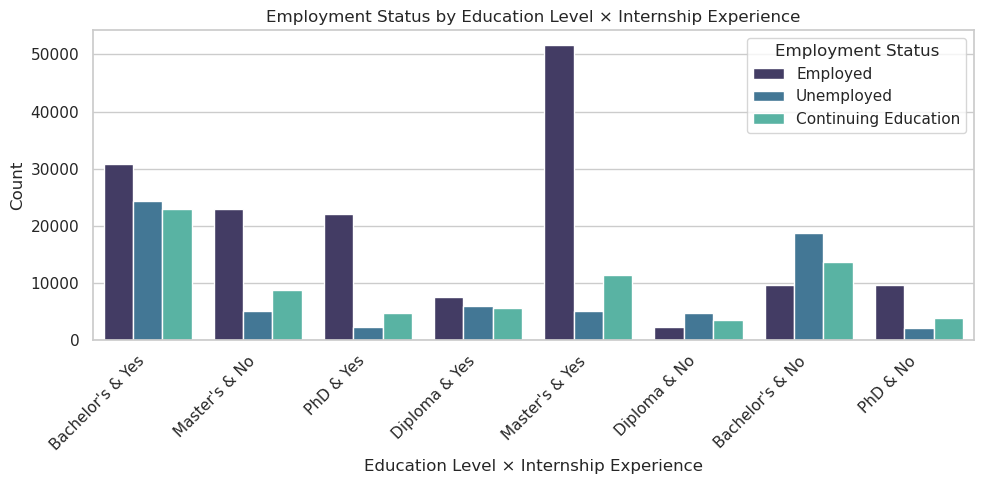


--- Ranked Associations by Cramér’s V ---
                                      Predictor        Type          Chi2  df  \
3        Language_Proficiency × Education_Level    Combined  95948.643265  30   
4  Language_Proficiency × Internship_Experience    Combined  54611.943356  14   
5       Education_Level × Internship_Experience    Combined  53467.799190  14   
0                          Language_Proficiency  Individual  47438.757753   6   
1                               Education_Level  Individual  46124.186996   6   
2                         Internship_Experience  Individual   6813.133383   2   

   p-value   CramerV  
3      0.0  0.399893  
4      0.0  0.301695  
5      0.0  0.298518  
0      0.0  0.281184  
1      0.0  0.277261  
2      0.0  0.150700  


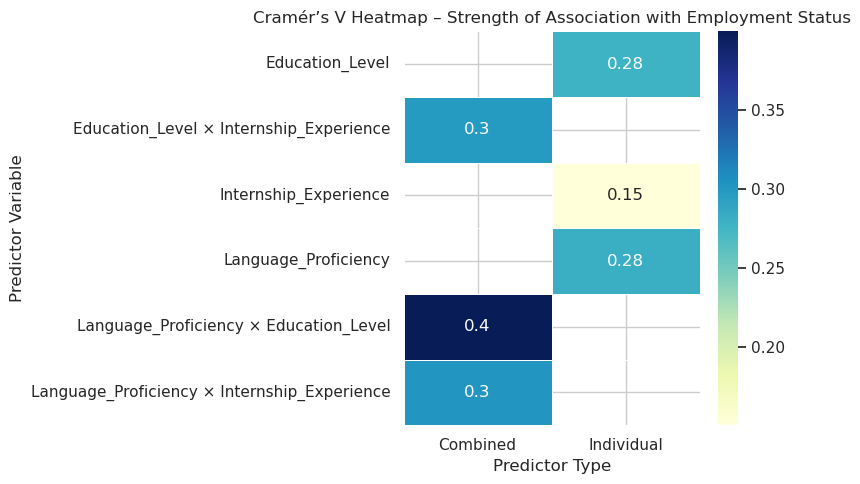


Results exported to ChiSquare_CramersV_EmploymentStatus_withHeatmap.csv


In [8]:
# ============================================================
# 🎓 International Graduates Employment Dataset Analysis
# Research Question:
# "How do Language Proficiency, Education Level, and Internship Experience
# combine to determine Employment Status?"
# ============================================================

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

sns.set(style="whitegrid")

# === 2. Load Dataset ===
df = pd.read_csv("cleaned_dataset.csv")
print("Dataset shape:", df.shape)
print(df.head())

# ============================================================
# 3. Data Preparation
# ============================================================

cols = ['Language_Proficiency', 'Education_Level', 'Internship_Experience', 'Employment_Status']
df = df[cols].dropna()

for c in cols:
    df[c] = df[c].astype(str)

print("\nUnique values per variable:")
for c in cols:
    print(f"{c}: {df[c].unique()}")

# ============================================================
# 4. Helper Function – Cramér’s V
# ============================================================

def cramers_v(conf_matrix):
    """Compute Cramér’s V (effect size)."""
    chi2 = chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum().sum()
    r, k = conf_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

# ============================================================
# 5. Individual Predictor Analysis
# ============================================================

predictors = ['Language_Proficiency', 'Education_Level', 'Internship_Experience']
outcome = 'Employment_Status'
results = []

print("\n============================")
print("  Statistical Analysis for EMPLOYMENT STATUS")
print("============================")

for predictor in predictors:
    table = pd.crosstab(df[predictor], df[outcome], margins=True)
    print(f"\nContingency Table: {predictor} vs {outcome}")
    print(table)

    chi2, p, dof, expected = chi2_contingency(table.iloc[:-1, :-1])
    v = cramers_v(table.iloc[:-1, :-1])
    results.append({'Predictor': predictor, 'Type': 'Individual',
                    'Chi2': chi2, 'df': dof, 'p-value': p, 'CramerV': v})

    print(f"\nChi-square Results: χ²={chi2:.3f}, df={dof}, p={p:.4f}, Cramér’s V={v:.3f}")
    print("→ Significant association (p < 0.05)" if p < 0.05 else "→ No significant association (p ≥ 0.05)")

# ============================================================
# 6. Visualization – Individual Predictors
# ============================================================

for predictor in predictors:
    plt.figure(figsize=(7, 5))
    sns.countplot(data=df, x=predictor, hue=outcome, palette="viridis")
    plt.title(f"Employment Status by {predictor}")
    plt.xlabel(predictor.replace("_", " "))
    plt.ylabel("Count")
    plt.legend(title="Employment Status")
    plt.tight_layout()
    plt.show()

# ============================================================
# 7. Joint (Combined) Predictors
# ============================================================

print("\n============================")
print("  Statistical Analysis for COMBINED PREDICTORS")
print("============================")

combined_pairs = [
    ('Language_Proficiency', 'Education_Level'),
    ('Language_Proficiency', 'Internship_Experience'),
    ('Education_Level', 'Internship_Experience')
]

for pair in combined_pairs:
    combo_col = f"{pair[0]}_x_{pair[1]}"
    df[combo_col] = df[pair[0]] + " & " + df[pair[1]]

    table = pd.crosstab(df[combo_col], df[outcome], margins=True)
    print(f"\nContingency Table: {pair[0]} × {pair[1]} vs {outcome}")
    print(table)

    chi2, p, dof, expected = chi2_contingency(table.iloc[:-1, :-1])
    v = cramers_v(table.iloc[:-1, :-1])
    results.append({'Predictor': f"{pair[0]} × {pair[1]}", 'Type': 'Combined',
                    'Chi2': chi2, 'df': dof, 'p-value': p, 'CramerV': v})

    print(f"\nChi-square Results: χ²={chi2:.3f}, df={dof}, p={p:.4f}, Cramér’s V={v:.3f}")
    print("→ Significant association (p < 0.05)" if p < 0.05 else "→ No significant association (p ≥ 0.05)")

    # Visualization
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=combo_col, hue=outcome, palette="mako")
    plt.title(f"Employment Status by {pair[0].replace('_',' ')} × {pair[1].replace('_',' ')}")
    plt.xlabel(f"{pair[0].replace('_',' ')} × {pair[1].replace('_',' ')}")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Employment Status")
    plt.tight_layout()
    plt.show()

# ============================================================
# 8. Summary Table
# ============================================================

results_df = pd.DataFrame(results).sort_values('CramerV', ascending=False)
print("\n--- Ranked Associations by Cramér’s V ---")
print(results_df)

# ============================================================
# 9. Cramér’s V Heatmap Visualization
# ============================================================

plt.figure(figsize=(8, 5))
heat_data = results_df.pivot(index='Predictor', columns='Type', values='CramerV')
sns.heatmap(heat_data, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Cramér’s V Heatmap – Strength of Association with Employment Status")
plt.xlabel("Predictor Type")
plt.ylabel("Predictor Variable")
plt.tight_layout()
plt.show()

# ============================================================
# 10. Save Results
# ============================================================

results_df.to_csv("ChiSquare_CramersV_EmploymentStatus_withHeatmap.csv", index=False)
print("\nResults exported to ChiSquare_CramersV_EmploymentStatus_withHeatmap.csv")
